In [16]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from libs import utils
from scipy.misc import imresize
from tensorflow.contrib import slim
%matplotlib inline

In [17]:
# Load a dataset
basedir = '/Users/VinaRahimian/Desktop/cozy interior designs _ Google Search'
files = os.listdir(basedir)
height = 64
width = 64

# empty list to hold all the images
imgs = []
for file_i in files:
    # load the image
    img = plt.imread(os.path.join(basedir, file_i))
    # convert RGBA -> RGB by removing any channels of color > 3
    if img.ndim == 3 and img.shape[2] > 3:
        img = img[..., :3]
    # convert grayscale to color:
    if img.ndim == 2:
        img = img[..., np.newaxis]
        img = np.concatenate(2, (img, img, img))
    # crop the image
    sqimg = utils.imcrop_tosquare(img)
    # resize the image
    rsz = imresize(sqimg, (height, width))
    # append to list of images
    imgs.append(rsz)

# the shape of the dataset should be: [100, 64, 64, 3]
print(np.array(imgs).shape)

(132, 64, 64, 3)


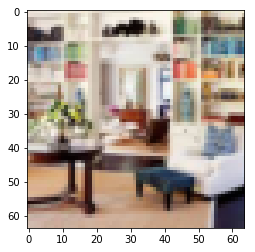

In [18]:
plt.imshow(imgs[50])

In [19]:
mean_img = np.mean(imgs, axis=0)
std_img = np.std(imgs, axis=0)
norm_imgs = (imgs - mean_img) / std_img

In [20]:
# Input placeholder, X: [None, 64, 64, 3]
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=[None, height, width, 3])

In [21]:
# Reshape it to be: [-1, 64 * 64 * 3]
X_reshape = tf.reshape(X, [-1, height * width * 3])

In [22]:
# Matrix multiply it using `slim.linear(X_reshape, 512, activation_fn=tf.nn.relu)`
H1 = slim.linear(X_reshape, 512, activation_fn=tf.nn.relu)
H2 = slim.linear(H1, 256, activation_fn=tf.nn.relu)
H3 = slim.linear(H2, 512, activation_fn=tf.nn.relu)

X_pred = slim.linear(H3, height * width * 3)

# Try different number of neuron combinations and activation functions

In [23]:
# Create a cost which is the per pixel difference
per_pixel_error = tf.square(X_pred - X_reshape)

# sum the difference to get a per feature_cost
per_image_error = tf.reduce_sum(per_pixel_error, 1)

# then get mean across batch
cost = tf.reduce_mean(per_image_error)

In [24]:
# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

In [25]:
len(norm_imgs)

132

0 9858.57
1 9041.93
2 8189.83
3 7016.69
4 6090.76
5 5063.92
6 3982.94
7 3169.6
8 2496.03
9 1993.55


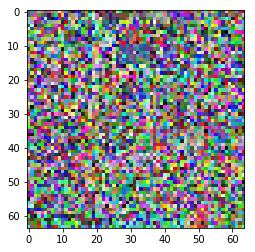

In [26]:
# Train

# create a session to manage graph
sess = tf.InteractiveSession()

# initialize all weights to random values
sess.run(tf.global_variables_initializer())

n_iterations = 10
batch_size = 25
for it_i in range(n_iterations):
    idxs = np.random.permutation(range(len(norm_imgs)))
    n_batches = len(idxs) // batch_size
    for batch_i in range(n_batches):
        idxs_i = idxs[batch_i * batch_size : (batch_i + 1) * batch_size]
        sess.run(optimizer, feed_dict={X: norm_imgs[idxs_i]})
    
    training_cost = sess.run(cost, feed_dict={X: norm_imgs})
    print(it_i, training_cost)
    
    # Create a synthesis of that guy
#     sess.run(X_pred, feed_dict={X: norm_imgs[50].reshape([1, height, width, 3])})
#     sess.run(X_pred, feed_dict={X: np.expand_dims(norm_imgs[50], 0)})
    synthesis = sess.run(X_pred, feed_dict={X: norm_imgs[50][np.newaxis]})
    plt.imshow(synthesis.reshape(height, width, 3))

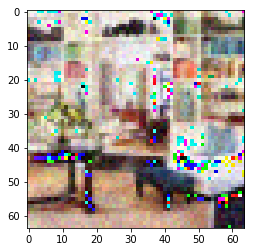

In [27]:
plt.imshow(((synthesis.reshape(height, width, 3) * std_img) + mean_img) / 255.0)

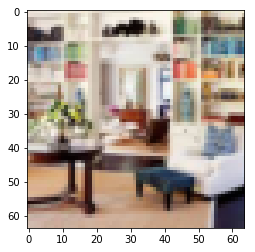

In [28]:
plt.imshow(imgs[50])

In [29]:
# Get synthesis of network using `X_pred`, and feeding `X` with a single image